Support code if promblems occour

In [ ]:
#TO EXECUTE ONLY IF IT IS NO POSSIBLE READ FROM VOCABULARY STORED ON THE DRIVE
voc = vocabulary(pth_glove)
torch.save(voc, pth_voc)

In [ ]:
#TO EXECUTE ONLY IF IT IS NO POSSIBLE READ FROM DICTIONARY STORED ON THE DRIVE
classes_dict_inv = invert_dictionary(classes_dict)
with open(pth_dict, 'w') as file_dict:
  file_dict.write(json.dumps(classes_dict_inv))

#Homework

#First Model: BiLSTN + Classifier

##Libraries and functions

In [ ]:
pip install seqeval

     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=fc897dfd0f78f7f88a51dbc699f84b8b59f47f17df3726613208fc9622df569a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
#import libraries

import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from typing import *
import string
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from seqeval.metrics import classification_report as seqeval_classification
from seqeval.metrics import f1_score as seqeval_f1_score
import matplotlib.pyplot as plt
import json

In [ ]:
pth_train = "/content/drive/MyDrive/data/train.tsv"
pth_dev = "/content/drive/MyDrive/data/dev.tsv"
pth_glove = "/content/drive/MyDrive/Copia di glove.6B.300d.txt"
pth_voc = "/content/drive/MyDrive/vocabulary.txt"
pth_dict = "/content/drive/MyDrive/dict.json"

In [ ]:
UNK = "unk"
PAD = "pad"

In [ ]:
#create a vocabulary that link each word to a set of tensor, using a pre-trained word embedding

def vocabulary(pth, PAD = "pad", UNK = "unk"):

  #read pre-trained glove model
  with open(pth) as f:
    glove = f.readlines()
  glove = [i.split(maxsplit = 1) for i in glove]

  #create a vocabulary from previous pre-trained model
  vocabulary = {}
  tensor = torch.tensor
  for w, vec in glove:
    vec = vec[:-2] #cut '\n'
    vec2 = vec.split()
    #i = 0
    #vec3 = [len(vec2)]
    vec3 = [np.float64(vec2[i]) for i in range(len(vec2))]
    tensor = torch.tensor(vec3)
    vocabulary.update({w:tensor})

  vocabulary.update({UNK:torch.ones(300)})
  vocabulary.update({PAD:torch.zeros(300)})

  return vocabulary

In [ ]:
def read_data(pth, PAD = "pad"):

  data = []
  labels = []
  original_labels = []
  original_data = []
  ids = []

  with open(pth) as file:

    tsv_file = csv.reader(file, delimiter="\t")

    #Loop to read data from files
    for line in tsv_file:

      if len(line)==0:
        data.append(word)
        original_data.append(data_or)
        labels.append(label)
        original_labels.append(label_or)

      elif line[0]=="#":
        ids.append(line[2])
        word = []
        label = []
        label_or = []
        data_or = []

      else:
        word.append(line[0])
        data_or.append(line[0])
        label.append(line[1])
        label_or.append(line[1])


    assert len(data) == len(labels)

    max_len = max(compute_lengths(data))
    
    for i in range(len(data)):
      while len(data[i])<max_len:
        data[i].append(PAD)
        labels[i].append(PAD)

    '''
    Retrun: 1.data with padding
            2.labels with padding
            3.data withouth padding
            4.labels withouth padding'''
    return data, labels, original_data, original_labels

In [ ]:
#compute leghts of different lists
#Return a list of lenghts
def compute_lengths(data):
    lenghts = []
    for x in data:
      lenghts.append(len(x))
    return lenghts

In [ ]:
#transformation of words in tensors using previos vocabulary
def VecFromWord(voc: dict, text: list):

  new_vecs = []

  for t in text:

    #associate each word in every text to a tensor, using the vocabulary(pre-trained word-embedding)
    vecs = transform(voc, t)

    # form: [[tensor1_1,....,tensor1_N],...,[tensorM_1,.....,tensorM_N]]
    new_vecs.append(vecs)

  print("Found "+str(len(new_vecs))+" samples.")

  return torch.stack(new_vecs)

#function for effective transormation
def transform(v: dict, l: list):

  vec = []

  for word in l:
    word = word.lower()
    if word in v.keys():
      vec.append(v[word])
    elif word == PAD:
      vec.append(v[PAD])
    else:
      vec.append(v[UNK])

  return torch.stack(vec)

In [ ]:
#Find the class belonging to data and encode in one-hot encoding

def define_classes(labels: list):

  new_list = []

  for l in labels:
    for li in l:
      new_list.append(li)

  #find number of different classes
  classes = []
  for i in np.unique(new_list):
    classes.append(i)
  num_class = len(classes)

  #associate an integer to each class
  classes_dict = {}
  counter = 0
  for elem in classes:
    if elem not in classes_dict.keys():
        classes_dict[elem]=counter
        counter+=1

  print("Found "+str(num_class)+" classes")

  #create a dictionary where each int correspond to a classe encoded with one-hot encoding
  ref = list(classes_dict.values())
  app = torch.tensor(ref)
  new_labels = list(F.one_hot(app, num_classes=num_class))
  one_hot_dict = {}
  for i,j in zip(ref,new_labels):
    one_hot_dict.update({i:j})

  #create a set inf form: [[tenso1_1,...tensor1_N],...,[tensorM_1,...tensorM_N]]
  #where each list of tensors is a class represented in one-hot encoding

  Y = []
  for l in labels:
    y = []
    for li in l:
      #if li != PAD:
      y.append(one_hot_dict.get(classes_dict.get(li)))
      #else:
        #y.append(torch.zeros(13))
    Y.append(torch.stack(y))
  #y = torch.stack(y).squeeze()

  return torch.stack(Y), classes_dict

In [ ]:
#create a dataset linking each text to its class, useful to pass data at the classification model
def create_dataset(x,y,batch_size):
  dataset = []
  dataset = [(data,label) for data,label in zip(x,y)]
  return DataLoader(dataset, batch_size)

In [ ]:
#Re-build a List[List[str]] both for true labels and predicted labels
#Needed to evaluate the model with seqeval
def data_for_evaluation(true,pred,lenghts,classes_dict_inv):

  y_true = []
  y_pred = []

  Y_true = []
  Y_pred = []

  cont1 = 0
  cont2 = 0

  for i in range(len(lenghts)):

    y_true = []
    y_pred = []

    cont1+=cont2
    cont2=0

    for j in range(lenghts[i]):
      y_true.append(classes_dict_inv.get(str(true[j+cont1])))
      y_pred.append(classes_dict_inv.get(str(pred[j+cont1])))
      cont2+=1

    Y_true.append(y_true)
    Y_pred.append(y_pred)
  
  #Rutrun labels withouth padding and prediction withouth padding, both List[List[str]]
  return Y_true, Y_pred

In [ ]:
#fuction to invert keys and values of a dictionary
def invert_dictionary(classes: dict):

  items_list = classes.items()
  new_dict = {}
  for i in list(items_list):
    new_dict.update({i[1]:i[0]})

  return new_dict

In [ ]:
def plot_classification_report(y, pred, classes: list):
  
  print('Classification Report')
  print(classification_report(y, pred, target_names=classes))

In [ ]:
def plot_confusion_matrix(y: np.array, pred: np.array, classes: list):
  
  print('Confusion Matrix')
  cm = confusion_matrix(y, pred)
  classes = classes
  fig, ax = plt.subplots(figsize=(9,9))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
           title='Test set',
           ylabel='True label',
           xlabel='Predicted label')
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
  fig.tight_layout()

In [ ]:
def plot_train_trend(train_loss: list, validation_loss: list, title: str):

  plt.plot(range(len(train_loss)),train_loss)
  plt.plot(range(len(validation_loss)),validation_loss)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(title)
  plt.legend(['Train loss', 'Validation loss'], loc='upper left')
  plt.show

In [ ]:
def plot_histogram(labels, title):

  histogram = {}
  c=0
  for l in labels:
    for el in l:
      if el not in histogram.keys():
        histogram.update({el:1})
      else:
        c = histogram.get(el)
        c=c+1
        histogram.update({el:c})

  histogram.pop(PAD)
  values = []
  for k in histogram.keys():
    values.append(histogram.get(k))

  keys = list(histogram.keys())

  fig, ax = plt.subplots(figsize=(10,5))
  plt.title(title) 
  plt.bar(keys, values, log=True)
  plt.plot()
  plt.show()

In [ ]:
def train(model, optimizer, data_train, data_val, loss_f, epochs: int = 10):

    tot_loss_train = []
    tot_loss_val = []
    
    for epoch in range(epochs):
        
        print("\nepoch: "+str(epoch+1)+"/"+str(epochs))

        #training loop
        loss_train = []  
        for x, y in data_train:

            optimizer.zero_grad()
            out = model(x.type(torch.float))
            out = out.view(-1, out.shape[-1])
            y = y.view(-1, y.shape[-1])
            y = torch.argmax(y, -1)
            loss = loss_f(out, y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        loss_val = []
        for x, y in data_val:

            out = model(x.type(torch.float))
            out = out.view(-1, out.shape[-1])
            y = y.view(-1, y.shape[-1])
            y = torch.argmax(y, -1)
            loss = loss_f(out, y)
            loss_val.append(loss.item())

        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

    return tot_loss_train, tot_loss_val

In [ ]:
def test(model: nn.Module, dataloader: DataLoader):

  num_true = 0
  pred = []
  true = []
  tot=0

  for x, y in dataloader:

      with torch.no_grad():
        out = model(x.type(torch.float))

      for elem_pred,elem_true in zip(torch.argmax(out, -1), torch.argmax(y, -1)):

          for e_pred,e_true in zip(elem_pred,elem_true):

            e_pred = e_pred.item()
            e_true = e_true.item()

            if e_pred == e_true: 
              num_true += 1
            if e_true!=13:
              tot+=1
              true.append(e_true)
              pred.append(e_pred)

  print(num_true,"/",tot)
  print(f'# accuracy: {(num_true / tot):.2f}')
  return true, pred

##Read and organize data

In [ ]:
#Read vocabulary (word embeddings)
voc = torch.load(pth_voc)

In [ ]:
#Read dictionary where the keys are integers and values are the associated classes
file_dict=open(pth_dict, 'r')
classes_dict_inv = json.loads(file_dict.read())

In [ ]:
'''
Read data (train and dev) from files
Return: 1.data with padding
        2.labels with padding
        3.data without padding
        4.labels withouth padding
'''
data, labels, original_data, original_labels = read_data(pth_train)
data_dev, labels_dev, original_data_dev, original_labels_dev = read_data(pth_dev)

In [ ]:
#Convert data into associated tensors
new_data = VecFromWord(voc, data)
new_data_dev = VecFromWord(voc, data_dev)

#Convert labels into one-hot encoding notation
new_labels, classes_dict = define_classes(labels)
new_labels_dev, _ = define_classes(labels_dev)

print("Shape of train data: "+str(new_data.shape))
print("Shape of train labels: "+str(new_labels.shape)) 
print("Shape of dev data: "+str(new_data_dev.shape))
print("Shape of dev labels: "+str(new_labels_dev.shape)) 

Found 14535 samples.
Found 765 samples.
Found 14 classes
Found 14 classes
Shape of train data: torch.Size([14535, 41, 300])
Shape of train labels: torch.Size([14535, 41, 14])
Shape of dev data: torch.Size([765, 34, 300])
Shape of dev labels: torch.Size([765, 34, 14])


In [ ]:
#HYPERPARAMETERS
N_FEATURES = new_data.shape[2]
N_HIDDEN = 100
N_CLASSES = new_labels.shape[2]-1
EPOCHS = 35
LOSS = nn.CrossEntropyLoss(ignore_index=13)
BATCH = 256

In [ ]:
#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(new_data,new_labels, test_size = 0.1, random_state = 43)
#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(new_data_dev,new_labels_dev, BATCH)

##Model, training, test

In [ ]:
#Definition of the model
class NERClassifier(torch.nn.Module):

    def __init__(self, embedding_dim, n_hidden, classes):
        super(NERClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional = True, num_layers = 2, dropout=0.3, batch_first = True)
        self.hidden1 = torch.nn.Linear(2*n_hidden, 100)
        self.hidden2 = torch.nn.Linear(100,80)
        self.hidden3 = torch.nn.Linear(80,50)
        self.hidden4 = torch.nn.Linear(50,classes)

    def forward(self, sentence):
        out, _ = self.lstm(sentence)
        out = self.hidden1(out)
        out = torch.relu(out)
        out = nn.Dropout(0.2)(out)
        out = self.hidden2(out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden3(out)
        out = torch.relu(out)
        out = nn.Dropout(0.2)(out)
        out = self.hidden4(out)
        out = F.log_softmax(out, dim=2)
        return out

In [ ]:
#Model Instance
model = NERClassifier(N_FEATURES, N_HIDDEN, N_CLASSES)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
#ONLY TO LOAD A SAVED MODEL
model = torch.load("/content/drive/MyDrive/model.pt")

In [ ]:
#Train the model
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/35
Train Loss: 1.3747010082006454
Validation Loss: 0.943508913119634


epoch: 2/35
Train Loss: 0.8767197063336005
Validation Loss: 0.7422666251659393


epoch: 3/35
Train Loss: 0.7119508683681488
Validation Loss: 0.6597866912682852


epoch: 4/35
Train Loss: 0.6218213954797158
Validation Loss: 0.5497797131538391


epoch: 5/35
Train Loss: 0.507758151453275
Validation Loss: 0.4665103554725647


epoch: 6/35
Train Loss: 0.3883328658456986
Validation Loss: 0.3651648958524068


epoch: 7/35
Train Loss: 0.3114625307229849
Validation Loss: 0.3466644038756688


epoch: 8/35
Train Loss: 0.2603884015518885
Validation Loss: 0.29347726702690125


epoch: 9/35
Train Loss: 0.22077621505237544
Validation Loss: 0.2850275784730911


epoch: 10/35
Train Loss: 0.19467744023467487
Validation Loss: 0.27586541573206586


epoch: 11/35
Train Loss: 0.1740569415000769
Validation Loss: 0.2837388863166173


epoch: 12/35
Train Loss: 0.14495510733328187
Validation Loss: 0.2714558740456899


epoch: 13/35
Train Lo

In [ ]:
#Compute prediction to test de model
true, pred = test(model, dataset_dev)

11758 / 12751
# accuracy: 0.92


In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/model.pt"
torch.save(model, pth_model, pickle_protocol=4)

##Graphs

Classification Report
              precision    recall  f1-score   support

      B-CORP       0.80      0.50      0.62       133
        B-CW       0.47      0.51      0.49       170
       B-GRP       0.72      0.67      0.69       190
       B-LOC       0.78      0.78      0.78       243
       B-PER       0.83      0.90      0.86       300
      B-PROD       0.60      0.50      0.55       149
      I-CORP       0.79      0.50      0.61       119
        I-CW       0.69      0.61      0.65       261
       I-GRP       0.81      0.72      0.77       377
       I-LOC       0.77      0.70      0.73       153
       I-PER       0.83      0.92      0.87       329
      I-PROD       0.65      0.59      0.61        87
           O       0.96      0.98      0.97     10240

    accuracy                           0.92     12751
   macro avg       0.75      0.68      0.71     12751
weighted avg       0.92      0.92      0.92     12751

Confusion Matrix
F1 score: 0.5874084700875751

          

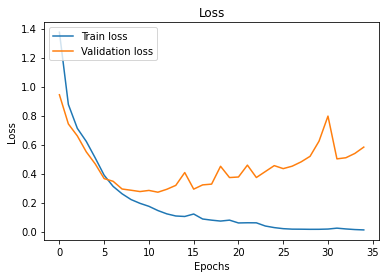

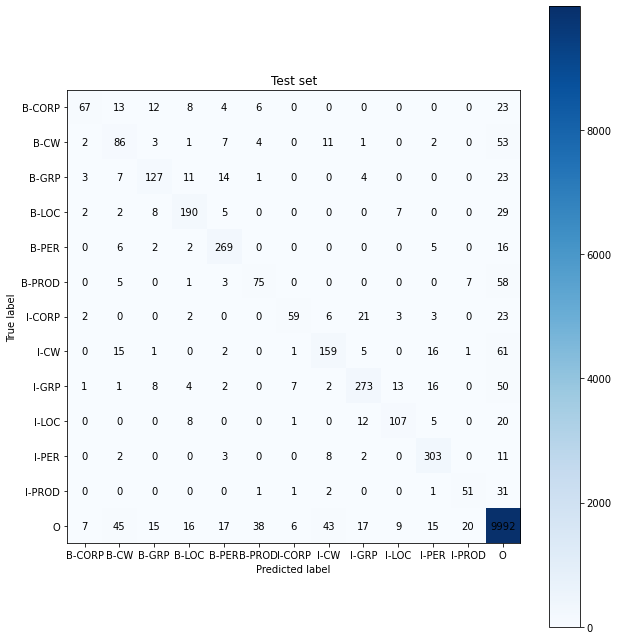

In [ ]:
#Plot Loss curves
plot_train_trend(loss_train, loss_val,"Loss")

#Classification report using sklearn
classes = list(classes_dict.keys())
classes.remove(PAD)
plot_classification_report(np.array(true), np.array(pred), classes)

#Confusion matrix
plot_confusion_matrix(true,pred,classes)

#F1 and classification report using seqeval

lenghts = compute_lengths(original_labels_dev)
''' Transorm 'true' and 'prediction', which are List[int],
    in List[List[str]], needed for seqeval evaluation'''
Y_true, Y_pred = data_for_evaluation(true, pred, lenghts, classes_dict_inv)
print("F1 score: "+str(seqeval_f1_score(Y_true, Y_pred, average="macro"))+"\n")
print(seqeval_classification(Y_true, Y_pred))

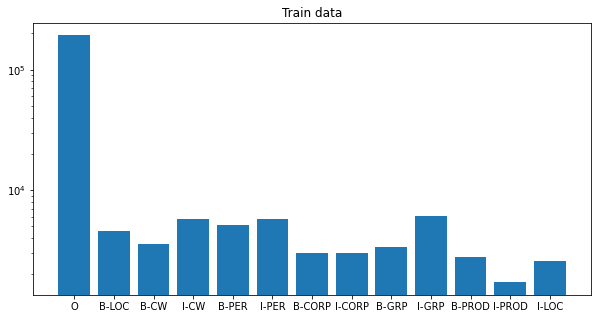

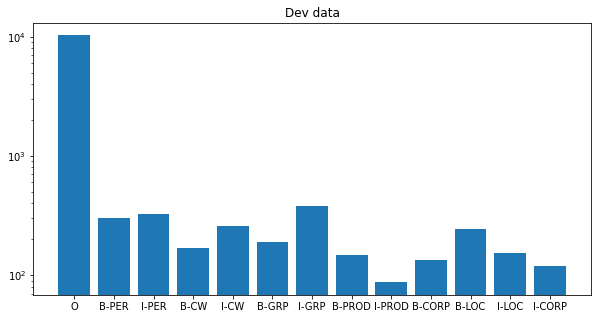

In [ ]:
#Plot histogram to visualize distribution of data labels
plot_histogram(labels, "Train data")
plot_histogram(labels_dev, "Dev data")

#POS

##Libreries and functions

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#Return Lis[List[str]] each str is the pos tag related to the word
def generate_pos_tags(original_data):
  #Associate pos tag to data (return [[(word1,pos_tag)...(wordN,pos_tag)]...[...]])
  pos_tag_data = []
  for d in original_data:
    pos_tag_data.append(nltk.pos_tag(d))

  #Do a list of List of List of pos tags related to a List of List of words
  data_pos_tags = []
  for t in pos_tag_data:
    pos_tags = []
    for ti in t:
      pos_tags.append(ti[1])
    data_pos_tags.append(pos_tags)

  #Add pad to pos tags
  max_len = max(compute_lengths(data_pos_tags))
  for d in data_pos_tags:
      while len(d)<max_len:
        d.append(PAD)

  return data_pos_tags

In [ ]:
#Return a dictionary {POS_TAG:INTEGER}, each integer correspond to a tag (0 is for padding)
def define_pos_voc(tags: list, PAD = "pad"):

  new_list = []

  for t in tags:
    for ti in t:
      new_list.append(ti)

  #find number of different classes
  pos_tags = []
  for i in np.unique(new_list):
    pos_tags.append(i)
  num_tags = len(pos_tags)

  #associate an integer to each class
  pos_dict = {}
  counter = 1
  for elem in pos_tags:
    if elem not in pos_dict.keys():
        pos_dict[elem]=counter
        counter+=1

  pos_dict.update({PAD:0})

  return pos_dict

In [ ]:
def embed_data(pos_voc, data, data_pos_tags, embedding):
  #Embedding with random tensors
  embedded_tags = []
  for sentence in data_pos_tags:
    emb_tag = []
    for tag in sentence:
      emb_tag.append(pos_voc.get(tag))
    embedded_tags.append(emb_tag)

  with torch.no_grad():
    new_pos = embedding(torch.LongTensor(embedded_tags))

  return new_pos, embedded_tags

In [ ]:
def embed_data2(pos_voc, data_pos_tags):
  #Embedding with random tensors
  embedded_tags = []
  for sentence in data_pos_tags:
    emb_tag = []
    for tag in sentence:
      emb_tag.append(pos_voc.get(tag))
    embedded_tags.append(emb_tag)

  return embedded_tags

In [ ]:
#Concatenate tensors of data
def concatenate_data_pos(data, tags):

  data_concat = []
  for i,j in zip(data,tags):
    data_concat.append(torch.cat((i,j), dim=1))

  return data_concat

##Model with embedding layer for POS

###Read data 

In [ ]:
#Generate POS tags associated to words
data_pos_tags = generate_pos_tags(original_data)
#Defina a dictionary of POS tgs
pos_voc = define_pos_voc(data_pos_tags)

In [ ]:
#Generate Pos taggers with pre-trainated pos tagging
pos = embed_data2(pos_voc, data_pos_tags)
data_pos_tags_dev = generate_pos_tags(original_data_dev)
pos_dev = embed_data2(pos_voc, data_pos_tags_dev)

In [ ]:
#Convert pos taggers list in array
pos = np.array(pos)
pos = np.reshape(pos, (pos.shape[0],pos.shape[1],1))
pos_dev = np.array(pos_dev)
pos_dev = np.reshape(pos_dev, (pos_dev.shape[0],pos_dev.shape[1],1))

In [ ]:
#split training set into train and validation to train and to evaluate the model
x_pos_train, x_pos_val, y_pos_train, y_pos_val = train_test_split(pos, new_labels, test_size = 0.1, random_state = 43)
#Define dataset from data for the input of the model
dataset_pos_train = create_dataset(x_pos_train, y_pos_train, BATCH)
dataset_pos_val = create_dataset(x_pos_val, y_pos_val, BATCH)
dataset_pos_dev = create_dataset(pos_dev, new_labels_dev, BATCH) 

###Model class and training and test functions


In [ ]:
#Definition of the model
class NERClassifierPOS(torch.nn.Module):

    def __init__(self, embedding_dim, n_hidden, classes, pos_voc):
        super(NERClassifierPOS, self).__init__()
        self.embedding = nn.Embedding(len(pos_voc), 300, padding_idx=40)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional = True, num_layers = 2, dropout=0.3, batch_first = True) 
        self.hidden1 = torch.nn.Linear(2*n_hidden, 100)
        self.hidden2 = torch.nn.Linear(100,80)
        self.hidden3 = torch.nn.Linear(80,50)
        self.hidden4 = torch.nn.Linear(50,classes)

    def forward(self, sentence):
        out_pos = self.embedding(sentence)
        #print(sentence.shape)
        out, _ = self.lstm(out_pos)
        out = self.hidden1(out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden2(out)
        out = torch.relu(out)
        out = nn.Dropout(0.4)(out)
        out = self.hidden3(out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden4(out)
        out = F.log_softmax(out, dim=2)
        return out

In [ ]:
def train2(model, optimizer, data_train, data_val, loss_f, epochs: int = 10):

    tot_loss_train = []
    tot_loss_val = []
    
    for epoch in range(epochs):
        
        print("\nepoch: "+str(epoch+1)+"/"+str(epochs))

        loss_train = []  
        for x, y in data_train:

            optimizer.zero_grad()
            x = torch.LongTensor(x)
            out = model(x.squeeze())
            out = out.view(-1, out.shape[-1])
            y = y.view(-1, y.shape[-1])
            y = torch.argmax(y, -1)
            loss = loss_f(out, y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        loss_val = []
        for x, y in data_val:

            x = torch.LongTensor(x)
            out = model(x.squeeze())
            out = out.view(-1, out.shape[-1])
            y = y.view(-1, y.shape[-1])
            y = torch.argmax(y, -1)
            loss = loss_f(out, y)
            loss_val.append(loss.item())

        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

    return tot_loss_train, tot_loss_val

In [ ]:
def test2(model: nn.Module, dataloader: DataLoader):
  num_true = 0
  pred = []
  true = []
  tot=0

  for x, y in dataloader:

      with torch.no_grad():
        x = torch.LongTensor(x)
        out = model(x.squeeze())#.type(torch.float))

      for elem_pred,elem_true in zip(torch.argmax(out, -1), torch.argmax(y, -1)):

          for e_pred,e_true in zip(elem_pred,elem_true):

            e_pred = e_pred.item()
            e_true = e_true.item()

            if e_pred == e_true: 
              num_true += 1
            if e_true!=13:
              tot+=1
              true.append(e_true)
              pred.append(e_pred)

  print(num_true,"/",tot)
  print(f'# accuracy: {(num_true / tot):.2f}')
  return true, pred

###Train and test model

In [ ]:
#Model Instance
model = NERClassifierPOS(300, 100, N_CLASSES, pos_voc)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
#Train the model
loss_train, loss_val = train2(model, optimizer, dataset_pos_train, dataset_pos_val, LOSS, 50)

In [ ]:
#ONLY TO LOAD A SAVED MODEL
model = torch.load("/content/drive/MyDrive/modelPOS.pt")

In [ ]:
#Compute prediction to test de model
true, pred = test2(model, dataset_pos_dev)

10565 / 12751
# accuracy: 0.83


In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPOS.pt"
torch.save(model, pth_model, pickle_protocol=4)

##Random pos tagging (out from model)
Model used: the first described, "NERClassifier"

In [ ]:
data_pos_tags = generate_pos_tags(original_data)
pos_voc = define_pos_voc(data_pos_tags)

In [ ]:
embedding = nn.Embedding(len(pos_voc), 100, padding_idx=40)

In [ ]:
pos_tags, list_of_tags = embed_data(pos_voc, new_data, data_pos_tags, embedding)
data_concat = concatenate_data_pos(new_data, pos_tags)

data_pos_tags_dev = generate_pos_tags(original_data_dev)
pos_tags_dev, list_of_tags_dev = embed_data(pos_voc, new_data_dev, data_pos_tags_dev, embedding)
data_concat_dev = concatenate_data_pos(new_data_dev, pos_tags_dev)

In [ ]:
#split training set into train and validation to train and to evaluate the model
x_pos_train, x_pos_val, y_pos_train, y_pos_val = train_test_split(data_concat, new_labels, test_size = 0.1, random_state = 43)
#Define dataset from data for the input of the model
dataset_pos_train = create_dataset(x_pos_train, y_pos_train, BATCH)
dataset_pos_val = create_dataset(x_pos_val, y_pos_val, BATCH)
dataset_pos_dev = create_dataset(data_concat_dev, new_labels_dev, BATCH) 

In [ ]:
#Model Instance
model = NERClassifier(400, 100, N_CLASSES)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
loss_train, loss_val = train(model, optimizer, dataset_pos_train, dataset_pos_val, LOSS, 25)

In [ ]:
#Compute prediction to test de model
true, pred = test(model, dataset_pos_dev)

##Graphs

Classification Report
              precision    recall  f1-score   support

      B-CORP       0.20      0.07      0.10       133
        B-CW       0.48      0.08      0.14       170
       B-GRP       0.37      0.31      0.33       190
       B-LOC       0.45      0.42      0.43       243
       B-PER       0.41      0.58      0.48       300
      B-PROD       1.00      0.01      0.01       149
      I-CORP       0.17      0.08      0.10       119
        I-CW       0.63      0.15      0.24       261
       I-GRP       0.41      0.42      0.41       377
       I-LOC       0.43      0.18      0.25       153
       I-PER       0.41      0.63      0.49       329
      I-PROD       0.20      0.02      0.04        87
           O       0.91      0.95      0.93     10240

    accuracy                           0.83     12751
   macro avg       0.47      0.30      0.31     12751
weighted avg       0.81      0.83      0.81     12751

Confusion Matrix
F1 score: 0.17079131304468176

         

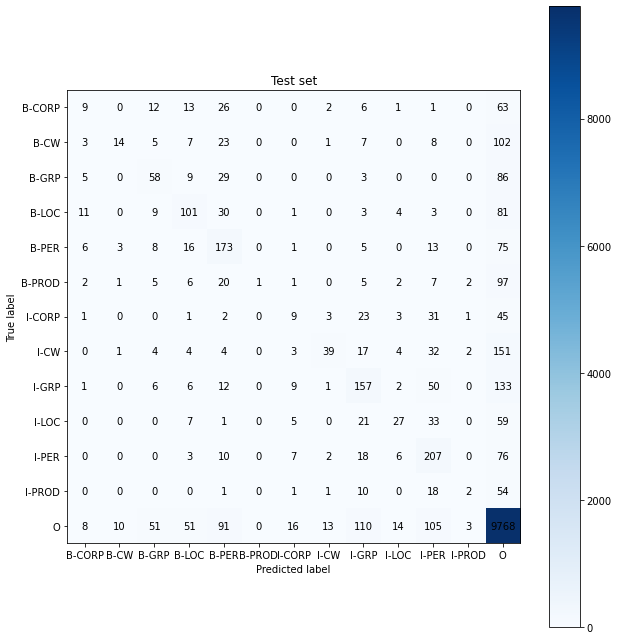

In [ ]:
#Plot Loss curves
plot_train_trend(loss_train, loss_val,"Loss")

#Classification report using sklearn
classes = list(classes_dict.keys())
classes.remove(PAD)
plot_classification_report(np.array(true), np.array(pred), classes)

#Confusion matrix
plot_confusion_matrix(true,pred,classes)

#F1 and classification report using seqeval

lenghts = compute_lengths(original_labels_dev)
''' Transorm 'true' and 'prediction', which are List[int],
    in List[List[str]], needed for seqeval evaluation'''
Y_true, Y_pred = data_for_evaluation(true, pred, lenghts, classes_dict_inv)
print("F1 score: "+str(seqeval_f1_score(Y_true, Y_pred, average="macro"))+"\n")
print(seqeval_classification(Y_true, Y_pred))

#CRF

In [ ]:
!pip install pytorch-crf
import torch
from torchcrf import CRF

##Model, training and test functions

In [ ]:
#Definition of the model
class NERClassifierCRF(torch.nn.Module):

    def __init__(self, classes, embedding_dim, n_hidden, training = False):
        super(NERClassifierCRF, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional = True, num_layers = 2, dropout=0.3, batch_first = True)
        
        self.hidden1 = torch.nn.Linear(2*n_hidden,100)
        self.hidden2 = torch.nn.Linear(100,80)
        self.hidden3 = torch.nn.Linear(80,50)
        self.hidden4 = torch.nn.Linear(50,classes+1)
        self.crf = CRF(classes+1, batch_first = True)


    def forward(self, sentence, tags = None, masks=None):

        out, _ = self.lstm(sentence)


        out = self.hidden1(out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden2(out)
        out = torch.relu(out)
        out = nn.Dropout(0.4)(out)
        out = self.hidden3(out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden4(out)

        out = F.log_softmax(out, dim=2)

        #print(out.shape)
        #print(tags.shape)

        if tags is not None:
          loss = self.crf(out, tags, mask=masks, reduction="mean")
          #print(loss)
          return -loss
        else:
          out = self.crf.decode(out)
          return out

In [ ]:
def train3(model, optimizer, data_train, data_val, loss_f, epochs: int = 10):

    tot_loss_train = []
    tot_loss_val = []
    
    for epoch in range(epochs):
        
        print("\nepoch: "+str(epoch+1)+"/"+str(epochs))

        loss_train = []  
        for x, y in data_train:

            y2 = torch.argmax(y, -1)

            masks = []
            for yi in y2:
              mask = []
              for i in yi:
                i = i.item()
                if i!=13:
                  mask.append(1)
                else:
                  mask.append(0)
              masks.append(mask)

            masks = torch.tensor(masks, dtype=torch.bool)

            optimizer.zero_grad()
            loss = model(x.type(torch.float), y2, masks)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        loss_val = []
        for x, y in data_val:

            y = torch.argmax(y, -1)

            out = model(x.type(torch.float))
            out = torch.tensor(out, dtype=torch.float)
            loss = loss_f(out, y)
            loss_val.append(loss)

        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

    return tot_loss_train, tot_loss_val

In [ ]:
def test3(model: nn.Module, dataloader: DataLoader):
  num_true = 0
  pred = []
  true = []
  tot=0

  for x, y in dataloader:

      with torch.no_grad():
        out = model(x.type(torch.float))

      for elem_pred,elem_true in zip(out, y):

          elem_true = torch.argmax(elem_true, -1)

          for e_pred,e_true in zip(elem_pred,elem_true):

            e_true = e_true.item()

            if e_pred == e_true: 
              num_true += 1
            if e_true!=13:
              tot+=1
              true.append(e_true)
              pred.append(e_pred)

  print(num_true,"/",tot)
  print(f'# accuracy: {(num_true / tot):.2f}')
  return true, pred

In [ ]:
#A loss function for validation data
def loss_crf_function(pred, y):
  count = 0
  for pi,yi in zip(pred,y):
    #print(i)
    for i,j in zip(pi,yi):
      if i!=j:
        count+=1
  return count/len(pred)

##Read data, training and test

In [ ]:
#ONLY TO LOAD A SAVED MODEL
model = torch.load("/content/drive/MyDrive/modelCRF.pt")

In [ ]:
#Model Instance
model = NERClassifierCRF(N_CLASSES, N_FEATURES, N_HIDDEN)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(new_data, new_labels, test_size = 0.1, random_state = 43)
#Define dataset from data for the input of the model
dataset_train_crf = create_dataset(x_train, y_train, BATCH)
dataset_val_crf = create_dataset(x_val, y_val, BATCH)

In [ ]:
LOSS = loss_crf_function
loss_train, loss_val = train3(model, optimizer, dataset_train_crf, dataset_val_crf, LOSS, EPOCHS)


epoch: 1/35
Train Loss: 22.972698248349705


/usr/local/lib/python3.7/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Validation Loss: 27.52749341475096


epoch: 2/35
Train Loss: 14.02434257360605
Validation Loss: 27.52749341475096


epoch: 3/35
Train Loss: 11.533047364308285
Validation Loss: 27.52749341475096


epoch: 4/35
Train Loss: 10.192504699413593
Validation Loss: 27.14786877394636


epoch: 5/35
Train Loss: 8.921221962341896
Validation Loss: 26.81868115421456


epoch: 6/35
Train Loss: 7.586623998788687
Validation Loss: 26.508149245689655


epoch: 7/35
Train Loss: 6.433553640659039
Validation Loss: 26.410986889367816


epoch: 8/35
Train Loss: 5.678015461334815
Validation Loss: 26.157290170019156


epoch: 9/35
Train Loss: 5.058599843428685
Validation Loss: 26.054650083812263


epoch: 10/35
Train Loss: 4.555354214631594
Validation Loss: 25.942394037356323


epoch: 11/35
Train Loss: 4.161712884902954
Validation Loss: 25.901296096743295


epoch: 12/35
Train Loss: 3.7180268581096945
Validation Loss: 25.776587943007666


epoch: 13/35
Train Loss: 3.4153719200537753
Validation Loss: 25.697460189176244



In [ ]:
loss_train2, loss_val2 = train3(model, optimizer, dataset_train_crf, dataset_val_crf, LOSS, EPOCHS)

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelCRF.pt"
torch.save(model, pth_model, pickle_protocol=4)

In [ ]:
dataset_dev_crf = create_dataset(new_data_dev, new_labels_dev, BATCH)

In [ ]:
true, pred = test3(model, dataset_dev_crf)

11782 / 12751
# accuracy: 0.92


##Graphs

Classification Report
              precision    recall  f1-score   support

      B-CORP       0.69      0.56      0.62       133
        B-CW       0.56      0.46      0.50       170
       B-GRP       0.79      0.68      0.73       190
       B-LOC       0.76      0.83      0.79       243
       B-PER       0.87      0.86      0.87       300
      B-PROD       0.54      0.46      0.49       149
      I-CORP       0.71      0.56      0.63       119
        I-CW       0.75      0.56      0.64       261
       I-GRP       0.85      0.73      0.79       377
       I-LOC       0.75      0.75      0.75       153
       I-PER       0.88      0.88      0.88       329
      I-PROD       0.64      0.53      0.58        87
           O       0.96      0.98      0.97     10240

    accuracy                           0.92     12751
   macro avg       0.75      0.68      0.71     12751
weighted avg       0.92      0.92      0.92     12751

Confusion Matrix
F1 score: 0.6109026979185236

          

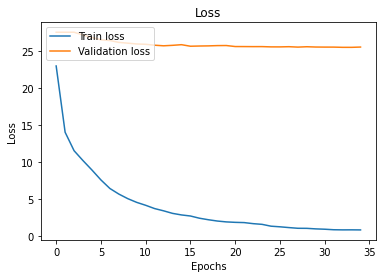

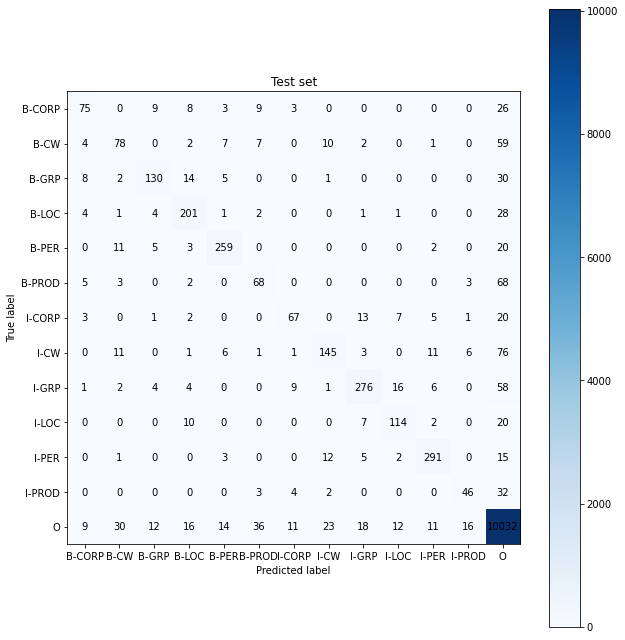

In [ ]:
#Plot Loss curves
plot_train_trend(loss_train, loss_val,"Loss")

#Classification report using sklearn
classes = list(classes_dict.keys())
classes.remove(PAD)
plot_classification_report(np.array(true), np.array(pred), classes)

#Confusion matrix
plot_confusion_matrix(true,pred,classes)

#F1 and classification report using seqeval

lenghts = compute_lengths(original_labels_dev)
''' Transorm 'true' and 'prediction', which are List[int],
    in List[List[str]], needed for seqeval evaluation'''
Y_true, Y_pred = data_for_evaluation(true, pred, lenghts, classes_dict_inv)
print("F1 score: "+str(seqeval_f1_score(Y_true, Y_pred, average="macro"))+"\n")
print(seqeval_classification(Y_true, Y_pred))